# 实验6 人名识别

本节课我们尝试处理序列化的数据。数据集中包含 $19$ 个国家的人名，人名只包含大小写英文字母，可以视为序列数据，请尝试使用任何你能想到的方法（例如 LSTM 等），预测测试数据集 `test_name_list.txt` 中每个人名是哪个国家的。

下面给出了一段简短的代码，没有使用任何机器学习和深度学习算法，用人名包含的字符串字串匹配进行暴力预测，该算法在训练数据集上可以达到 $93\%$ 的准确率，在测试集上可以达到 $76\%$ 的准确率，可将该算法作为 baseline.

**本次实验除了提交实验报告外，还需将测试数据集的结果以 test_label_list_predict.txt 提交，格式可参考 train_label_list.txt**

In [20]:
def build_dict(name_list):
    dic={}
    for name in name_list:
        for L in range(2,5):
            for i in range(len(name)-L):
                dic[name[i:i+L]]=0
    return dic

def build_all_dic(train_name_list,train_label_list):
    labels=sorted(list(set(train_label_list)))
    dic={}
    for label in labels:
        dic[label]=build_dict([i for i,j in zip(train_name_list,train_label_list) if j==label])
    return dic

def predict(dic,name):
    num={i:0 for i in dic}
    for L in range(2,5):
        for i in range(len(name)-L):
            for label in dic:
                if name[i:i+L] in dic[label]:
                    num[label]+=1
    max_num=max([num[i] for i in num])
    for i in num:
        if num[i]==max_num:
            return i

def judge(label_list,label_list_predict):
    correct=0
    for i,j in zip(label_list,label_list_predict):
        if i==j:
            correct+=1
    return correct/len(label_list)

train_name_list=open("train_name_list.txt","r").read().split()
train_label_list=open("train_label_list.txt","r").read().split()
test_name_list=open("test_name_list.txt","r").read().split()
#test_label_list=open("test_label_list.txt","r").read().split()

dic=build_all_dic(train_name_list,train_label_list)
train_label_list_predict=[predict(dic,name) for name in train_name_list]
print("train acc:",judge(train_label_list,train_label_list_predict))
test_label_list_predict=[predict(dic,name) for name in test_name_list]
with open("test_label_list_predict.txt","w") as f:
    for i in test_label_list_predict:
        f.write(i)
        f.write("\n")

train acc: 0.927496202182019


准备数据

In [21]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
#abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
n_letters = len(all_letters)

#把字符串s转换为Ascii码，便于统一格式
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

#{国家名：[包含的人名]}
category_lines = {}
#[所有国家名的集合]
all_categories = []

#读取文件，按换行分割
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]


name=readLines('train_name_list.txt')
label=readLines('train_label_list.txt')
all_categories=list(set(label))

#将名字按照国际分类
for category in all_categories:
    lines=[]
    for i in range(len(name)):
        if label[i]==category:
            lines.append(name[i])
    category_lines[category] = lines
    

#所有国家的数量
n_categories = len(all_categories)

把字符串转变为张量

In [22]:
import torch

#从all_letters中找到指定字符letter的下标
def letterToIndex(letter):
    return all_letters.find(letter)

#把一个字符转换为张量，独热编码的模式
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)#全0张量
    tensor[0][letterToIndex(letter)] = 1#指定位置置为1
    return tensor

#把一个字符串转换为一个三维张量{字符个数x1xn_letters}
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)#全0
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor


定义神经网络的结构

只构造包含三层的神经网络，输入层，隐藏层，输出层

In [23]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)#输入层加上上一次的隐藏层输出为隐藏层，供下一次使用
        self.i2o = nn.Linear(input_size + hidden_size, output_size)#输入层加上上一次的隐藏层输出为输出层
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)#输出是一个n_categories维的向量，代表了这个人名属于每个国家的概率
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)#刚开始隐藏层输出全部初始化为1

n_hidden =256
rnn = RNN(n_letters, n_hidden, n_categories)

从向量的输出中，找出最有可能的国家

In [24]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i


随机选择训练集

In [25]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]


#先从all_categories中随机选取国家，再从国家中随机选人名
def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor#输出为 国家名，人名，人名转换之后的张量


训练模型，输出损失值，梯度下降更新参数

In [26]:
criterion = nn.NLLLoss()#损失值的计算方式

learning_rate = 0.007# If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()#初始化隐藏层

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):#循环输入input中的每个字符的张量，获得隐藏层和输出层，隐藏层下一次使用
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)#计算最终输出和label的损失值
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():#对网络中的每个参数，减去梯度乘以学习率来更新参数
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()#输出 输出层和损失值


开始训练模型

In [27]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



#记录损失值
current_loss = 0
all_losses = []
accuraty_rate=[]
right_count=0

#计算输出从开始到目前所用时间
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    guess, guess_i = categoryFromOutput(output)
    if guess==category:
        right_count+=1
    #打印训练过程
    if iter % print_every == 0:
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s%.4f' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct,right_count/print_every))
        right_count=0
    # 记录每一个阶段的平均损失率
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        #accuraty_rate.append(right_count/plot_every)
        current_loss = 0
        #right_count=0
        

5000 5% (0m 6s) 2.3954 Zabek / Czech ✗ (Polish)0.2254
10000 10% (0m 12s) 1.0986 Tieu / Vietnamese ✓0.3658
15000 15% (0m 17s) 0.9664 Orsini / Italian ✓0.4360
20000 20% (0m 23s) 0.2330 Mcdonald / Scottish ✓0.4848
25000 25% (0m 30s) 2.0313 Pfeifer / German ✗ (Czech)0.5190
30000 30% (0m 36s) 0.1326 Ishiguro / Japanese ✓0.5358
35000 35% (0m 41s) 0.1318 Corraidhin / Irish ✓0.5534
40000 40% (0m 47s) 2.2925 Fuentes / Portuguese ✗ (Spanish)0.5962
45000 45% (0m 53s) 1.4567 Dickson / Korean ✗ (Scottish)0.5624
50000 50% (0m 58s) 0.6528 Porras / Spanish ✓0.5816
55000 55% (1m 4s) 0.6608 Mui / Chinese ✓0.5920
60000 60% (1m 9s) 0.4537 Kim / Korean ✓0.6094
65000 65% (1m 15s) 0.5371 Kamo / Japanese ✓0.6042
70000 70% (1m 20s) 1.1891 Cruz / Portuguese ✓0.5986
75000 75% (1m 26s) 0.4779 Ricchetti / Italian ✓0.6120
80000 80% (1m 32s) 1.9275 Sessa / Spanish ✗ (Italian)0.6174
85000 85% (1m 37s) 0.1131 Ddz / Mars ✓0.6222
90000 90% (1m 43s) 1.8202 Pender / German ✗ (English)0.6092
95000 95% (1m 49s) 1.2074 Catta

画出损失率-迭代批次图

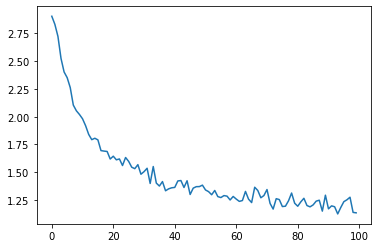

In [28]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

输出预测列表

In [39]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output
def predict(input_line, n_predictions=1):
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            predictions.append([all_categories[category_index]])
    return(predictions[0][0])


file_object = open('test_label_list_predict.txt', 'w')
name_test=readLines('test_name_list.txt')
for person in name_test:
    file_object.write(predict(person)+'\n')
file_object.close()